# Overview

This notebook builds a model that predicts whether a patient will have heart failure. It uses a [dataset from Kaggle](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data?select=heart_failure_clinical_records_dataset.csv) with 12 columns of clinical data from 300 patients. There is a prevelance of heart failure of 32%.

# Results
A logistic regression model is selected. It has a testing AUC of 73% and a precision-recall AUC of 52%.

* [1. Loading Libraries and Data](#1.LoadingLibrariesandData)
* [2. EDA](#2.EDA)
* [3. Preprocessing](#3.Preprocessing)
* [4. Modeling and Evaluation](#4.ModelingandEvaluation)
    * [4.1. Logisitic Regression](#4.1.LogisiticRegression)
    * [4.2. Random Forest](#4.2.RandomForest)
    * [4.3. Gradient Boost](#4.3.GradientBoost)
* [5. Conclusion](#5.Conclusion)

## 1. Loading Libraries and Data <a class="anchor" id="1.LoadingLibrariesandData"></a>

In [1]:
#General Imports
import glob, os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.stats import uniform
from datetime import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#Sklearn imports
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_curve, plot_precision_recall_curve, precision_recall_curve, confusion_matrix, auc,plot_roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

In [2]:
os.chdir("../src/data")
from time_elapsed import time_elapsed
from PlotPrecisionRecall import Plot_PR
from PlotFeatureImportance import Plot_Feat_Imp
from CreateJupyterNotebookHeadings import jupyternotebookheadings1, jupyternotebookheadings2

In [3]:
#Load Data
os.chdir("../../data/raw")
df=pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [4]:
df=pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [5]:
#Get counts of missing variables
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [6]:
#Get value counts of predictor variable
df.DEATH_EVENT.value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

## 2. EDA <a class="anchor" id="2.EDA"></a>

In [8]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [9]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [10]:
#Drop time column - not of interest
df.drop(columns='time', inplace=True)

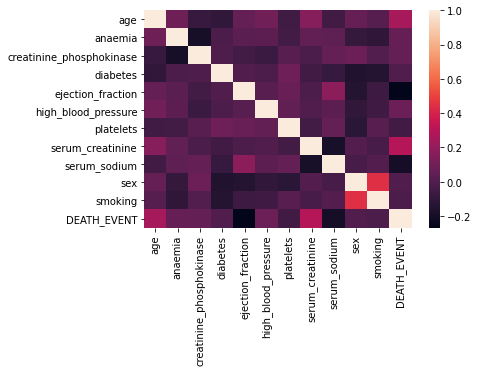

In [11]:
sns.heatmap(df.corr())
plt.show()
#No strong correaltions in data, aside from sex & smoking

In [46]:
df_norm=(df-df.min())/(df.max()-df.min())
df_norm.drop(columns=['anaemia','diabetes','high_blood_pressure','sex','smoking'],inplace=True)
dict_={1:'Heart Failure',0:'Survived'}
df_norm.DEATH_EVENT=df_norm.DEATH_EVENT.map(dict_)
df_metled=pd.melt(df_norm,id_vars='DEATH_EVENT',var_name='Clinical_Feature',value_name='Relative_Value')

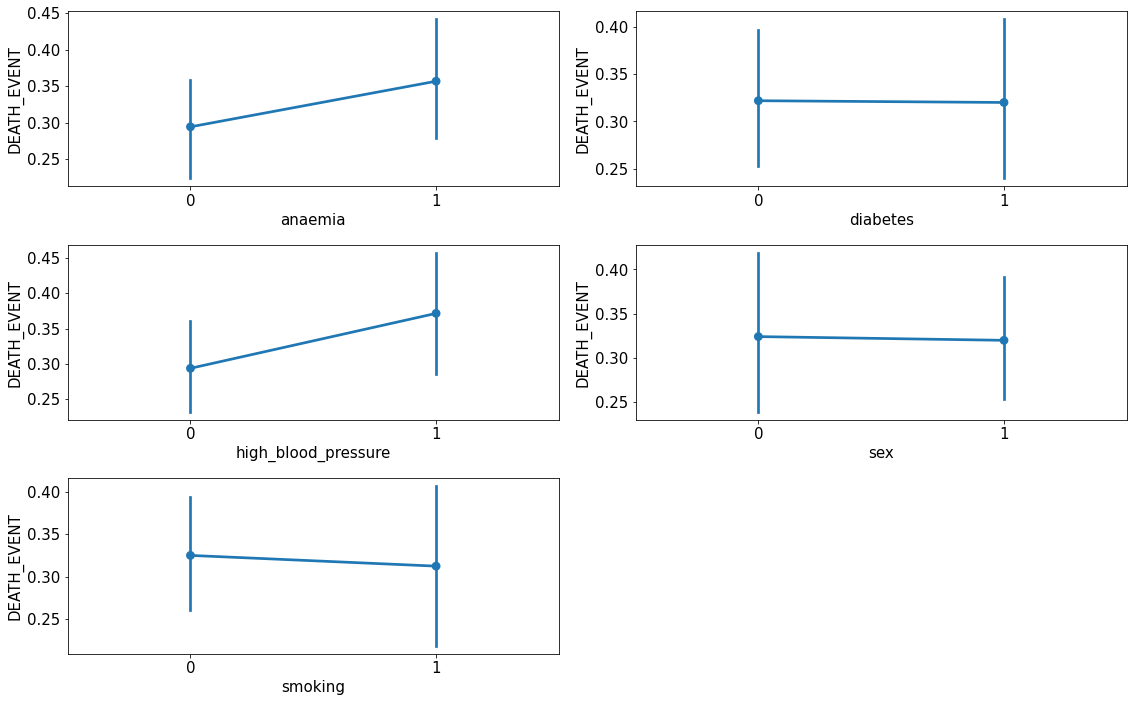

In [14]:
#Point Plots of Categorical Variables
df_cat=df[['anaemia','diabetes','high_blood_pressure','sex','smoking','DEATH_EVENT']]
plt.subplots(figsize=(16,10))
plt.rcParams.update({'font.size': 15})
plt.subplot(3,2,1)
sns.pointplot(x='anaemia',y='DEATH_EVENT',data=df_cat)
plt.subplot(3,2,2)
sns.pointplot(x='diabetes',y='DEATH_EVENT',data=df_cat)
plt.tight_layout()
plt.subplot(3,2,3)
sns.pointplot(x='high_blood_pressure',y='DEATH_EVENT',data=df_cat)
plt.subplot(3,2,4)
sns.pointplot(x='sex',y='DEATH_EVENT',data=df_cat)
plt.subplot(3,2,5)
sns.pointplot(x='smoking',y='DEATH_EVENT',data=df_cat)
plt.tight_layout()
plt.show()

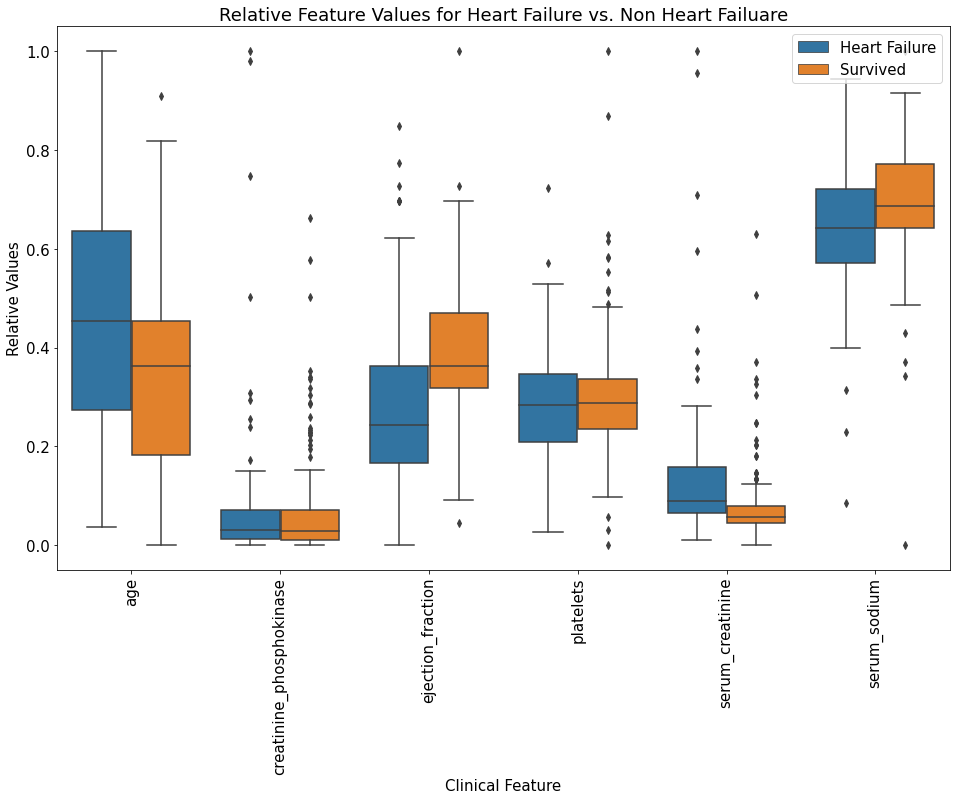

In [15]:
#Plot the distributions with boxplots
plt.subplots(figsize=(16,10))
sns.boxplot(x='Clinical_Feature',y='Relative_Value',hue='DEATH_EVENT',data=df_metled)
plt.xticks(rotation='vertical')
plt.ylabel('Relative Values')
plt.xlabel('Clinical Feature')
plt.title('Relative Feature Values for Heart Failure vs. Non Heart Failuare')
plt.legend(loc='upper right')
plt.show()

## 3. Preprocessing <a class="anchor" id="3.Preprocessing"></a>

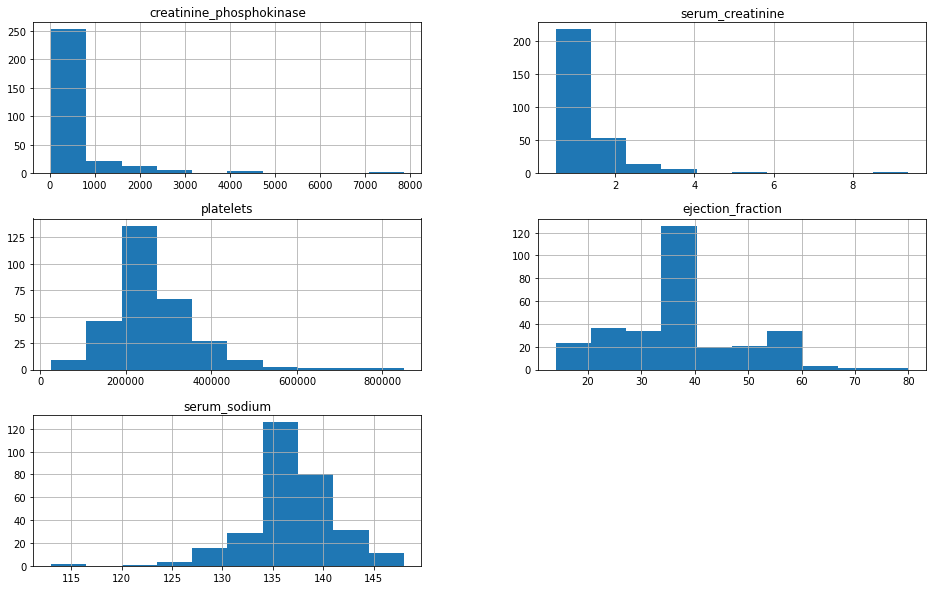

In [16]:
plt.rcParams.update({'font.size': 10})
df[['creatinine_phosphokinase','serum_creatinine','platelets','ejection_fraction','serum_sodium']].hist(figsize=(16,10))
plt.show()

In [17]:
list2=['creatinine_phosphokinase','serum_creatinine','platelets','ejection_fraction','serum_sodium']
def log_trans_columns(df,list_):
    for feature in list_:
        a=np.array(df[feature]).reshape(-1, 1)
        pow_trans = PowerTransformer()
        q=pow_trans.fit_transform(a)
        df[feature]=q
    return df

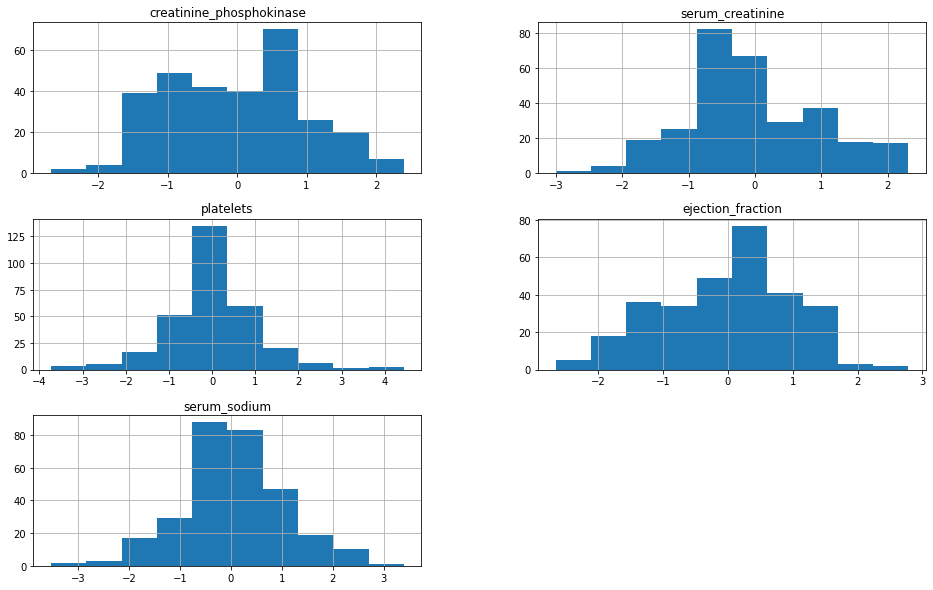

In [18]:
log_trans_columns(df,list2)[['creatinine_phosphokinase','serum_creatinine','platelets','ejection_fraction','serum_sodium']].hist(figsize=(16,10))
plt.show()

In [19]:
df=log_trans_columns(df,list2)

In [20]:
#Drop death event, as well as 4 of the categorical columns that have no discernable difference in distribution or any feature 
#Importance according to tree models. Since there are so few rows, need to have less columns or else could run into curse of dimensionality.
X=df.drop(columns=['DEATH_EVENT','sex','diabetes','smoking'])
y=df['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=30,stratify=y)

In [21]:
#Fit Standard Scaler to X_train data, transform X_train and X_test data
MM_scale=StandardScaler()
MM_scale.fit(X_train)
X_train=MM_scale.transform(X_train)
X_test=MM_scale.transform(X_test)

## 4. Modeling and Evaluation <a class="anchor" id="4.ModelingandEvaluation"></a>

### 4.1. Logisitic Regression <a class="anchor" id="4.1.LogisiticRegression"></a>

In [22]:
#Find optimal logsistic regression parameter
clf = LogisticRegression(random_state=42,max_iter=1000)
C=[1/(10**i) for i in range(2,10)]+[round(0.1*i,1) for i in range(1,10)]
distributions = {'C': C}
LR_RS=GridSearchCV(clf, distributions,n_jobs=-1,scoring='f1')
search_clf=LR_RS.fit(X_train, y_train)
best_dict=search_clf.best_params_
search_clf.best_params_

{'C': 0.5}

In [23]:
clf=LogisticRegression(random_state=35,C=best_dict['C'],max_iter=1000)
clf.fit(X_train,y_train)

LogisticRegression(C=0.5, max_iter=1000, random_state=35)

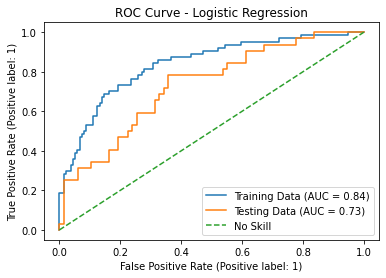

In [24]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(clf,X_train,y_train,ax=_,name='Training Data')
plot_roc_curve(clf,X_test,y_test,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Logistic Regression')
plt.show()

Best Train Threshold=0.403635, F-Score=0.688
Best Test Threshold=0.223010, F-Score=0.617
Train AUC: 0.734 Test AUC: 0.572


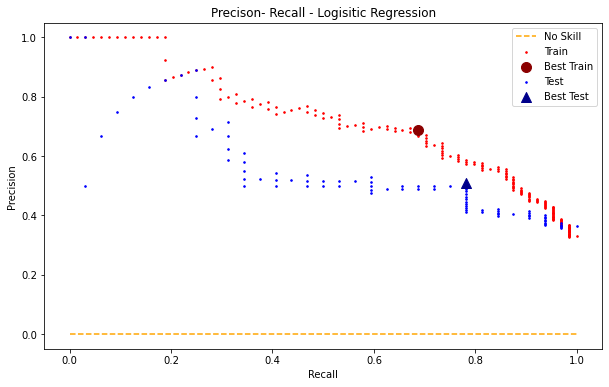

In [25]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Logisitic Regression'
prob=Plot_PR(clf,X_train,y_train,X_test,y_test,title,auc,precision_recall_curve,np,plt,(10,6))

In [53]:
#Return Classification Report of testing data with optimal train probability threshold
q=clf.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>0.22 else 0 for i in q]
print(classification_report(y_test,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.86      0.63      0.72        67
           1       0.50      0.78      0.61        32

    accuracy                           0.68        99
   macro avg       0.68      0.70      0.67        99
weighted avg       0.74      0.68      0.69        99



In [54]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test,y_pred_test_new))

[[42 25]
 [ 7 25]]


### 4.2. Random Forest <a class="anchor" id="4.2.RandomForest"></a>

In [28]:
#Randomized search for Gradient Boost Classifier, Sepsis Label
RFC = RandomForestClassifier(random_state=42)
min_samples_split = [4,7,12]
min_samples_leaf = [4,7,12]
max_features=[2,3,4,5]
max_depth=[2,5,10]
n_estimators=[10,25,100,250,500,750,1000]
distributions = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
                'max_features':max_features,
                'n_estimators': n_estimators}
RFC_GS=GridSearchCV(RFC,distributions,cv=3,n_jobs=-1,scoring='recall')
search_RFC=RFC_GS.fit(X_train,y_train)
best_dict=search_RFC.best_params_
search_RFC.best_params_

{'max_depth': 5,
 'max_features': 4,
 'min_samples_leaf': 7,
 'min_samples_split': 4,
 'n_estimators': 10}

In [29]:
#Create Model
RFC_=RandomForestClassifier(n_estimators=1000, min_samples_split=best_dict['min_samples_split'],
min_samples_leaf=best_dict['min_samples_leaf'], max_depth=best_dict['max_depth'],
max_features=best_dict['max_features'],random_state=42,n_jobs=-1)

RFC_.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, max_features=4, min_samples_leaf=7,
                       min_samples_split=4, n_estimators=1000, n_jobs=-1,
                       random_state=42)

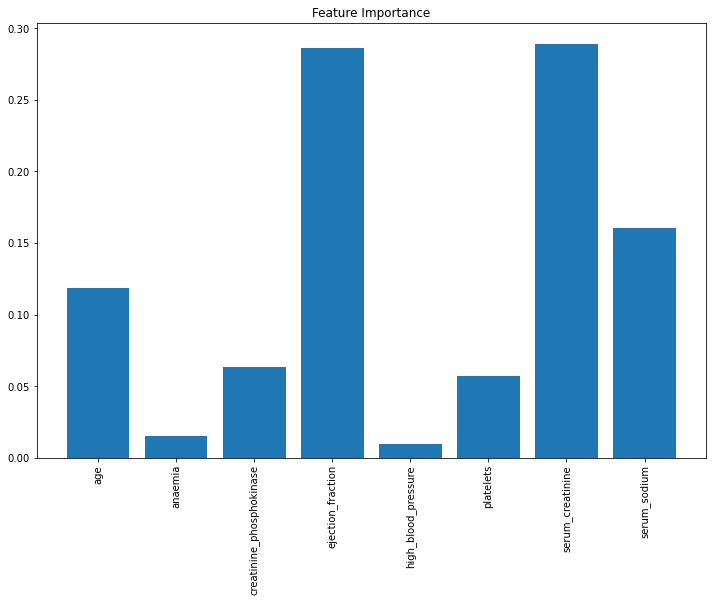

In [30]:
#Plot Feature Importance 
Plot_Feat_Imp(RFC_,X.columns,pd,np,plt,(12,8))

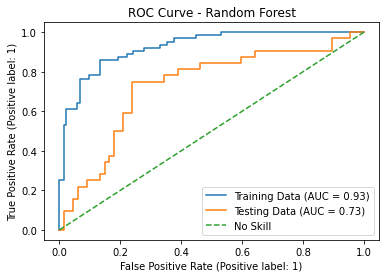

In [31]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(RFC_,X_train,y_train,ax=_,name='Training Data')
plot_roc_curve(RFC_,X_test,y_test,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Random Forest')
plt.show()

Best Train Threshold=0.479666, F-Score=0.803
Best Test Threshold=0.813414, F-Score=nan
Train AUC: 0.864 Test AUC: 0.512


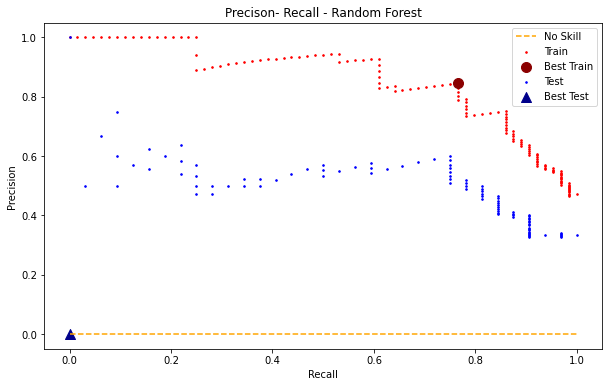

In [32]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Random Forest'
prob=Plot_PR(RFC_,X_train,y_train,X_test,y_test,title,auc,precision_recall_curve,np,plt,(10,6))

In [33]:
#Return Classification Report of testing data with optimal train probability threshold
q=RFC_.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>0.30 else 0 for i in q]
print(classification_report(y_test,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.85      0.67      0.75        67
           1       0.52      0.75      0.62        32

    accuracy                           0.70        99
   macro avg       0.69      0.71      0.68        99
weighted avg       0.74      0.70      0.71        99



In [34]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test,y_pred_test_new))

[[45 22]
 [ 8 24]]


### 4.3. Gradient Boost <a class="anchor" id="4.3.GradientBoost"></a>

In [35]:
#Randomized search for Gradient Boost Classifier, Sepsis Label
start = datetime.now()
GB = GradientBoostingClassifier(random_state=42)
max_depth = [3]
n_estimators=[10,25,50,75,100]
max_features=[2,3,4,5]
learning_rate=[0.01,0.001,0.0001]
distributions = {'max_depth': max_depth,'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_features':max_features}
GB_RS=GridSearchCV(GB,distributions,cv=3,n_jobs=-1,scoring='f1')
search_GB_Sepsis=GB_RS.fit(X_train,y_train)
end = datetime.now()
time_elapsed(start,end)
best_dict=search_GB_Sepsis.best_params_
search_GB_Sepsis.best_params_

This process took 00 Hours 00 Minutes 01 Seconds 


{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 4, 'n_estimators': 100}

In [36]:
#Create Model
start = datetime.now()
GB_=GradientBoostingClassifier(learning_rate=best_dict['learning_rate'],
n_estimators=best_dict['n_estimators'], max_features=best_dict['max_features'], max_depth=best_dict['max_depth'], random_state=42)
GB_.fit(X_train,y_train)
end = datetime.now()
time_elapsed(start,end)

This process took 00 Hours 00 Minutes 00 Seconds 


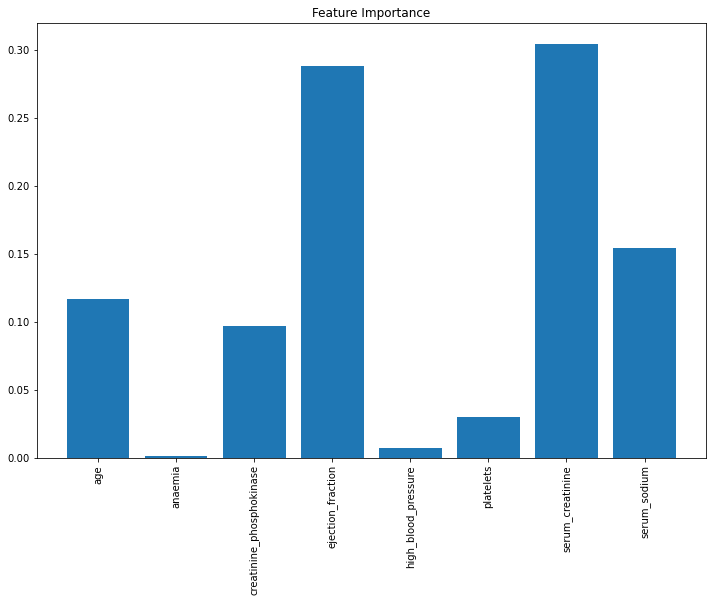

In [37]:
#Plot Feature Importance 
Plot_Feat_Imp(GB_,X.columns,pd,np,plt,(12,8))

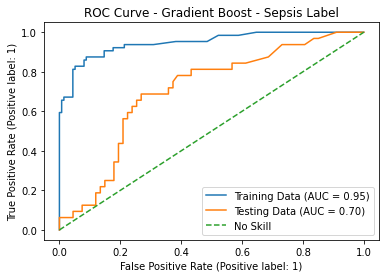

In [38]:
#Plot ROC Curve
_=plt.axes()
plot_roc_curve(GB_,X_train,y_train,ax=_,name='Training Data')
plot_roc_curve(GB_,X_test,y_test,ax=_,name='Testing Data')
_.plot([0,1],[0,1],label='No Skill',linestyle='--')
_.legend()
_.set_title('ROC Curve - Gradient Boost - Sepsis Label')
plt.show()

Best Train Threshold=0.408172, F-Score=0.855
Best Test Threshold=0.340900, F-Score=0.611
Train AUC: 0.922 Test AUC: 0.493


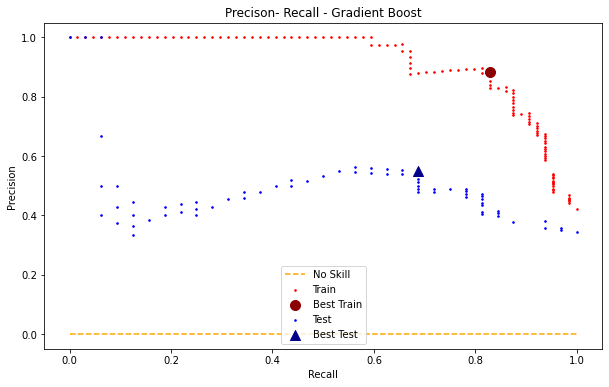

In [39]:
#Plot Precison-Recall Curve, determine optimal cutoff value
title='Precison- Recall - Gradient Boost'
prob=Plot_PR(GB_,X_train,y_train,X_test,y_test,title,auc,precision_recall_curve,np,plt,(10,6))

In [40]:
#Return Classification Report of testing data with optimal train probability threshold
q=GB_.predict_proba(X_test)[:,1]
y_pred_test_new=[1 if i>0.40 else 0 for i in q]
print(classification_report(y_test,y_pred_test_new))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        67
           1       0.56      0.56      0.56        32

    accuracy                           0.72        99
   macro avg       0.68      0.68      0.68        99
weighted avg       0.72      0.72      0.72        99



In [41]:
#Return Confusion Matrix of testing data with optimal train probability threshold
print(confusion_matrix(y_test,y_pred_test_new))

[[53 14]
 [14 18]]


## 5. Conclusion <a class="anchor" id="5.Conclusion"></a>

Logistic Regression is the best model. Overfits to training data the least, has as high a performance on testing data as Random Forest. Would set the probability threshold to 25% to improve recall; better to wrongly tell a patient they are at higher risk for a fatal heart issue than to wrongly tell them they are at no risk great risk.
Parameters and coefficients of the model are below.

In [57]:
clf.get_params()

{'C': 0.5,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 35,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [95]:
name=list(X.columns)
coef=list(clf.coef_[0,:])
for i in range(0,8):
    print(name[i],': ',coef[i])

age :  0.45837738261113253
anaemia :  0.3053406628128963
creatinine_phosphokinase :  0.3916226309853844
ejection_fraction :  -0.7202405207027812
high_blood_pressure :  0.2294963820365983
platelets :  -0.2549785930498846
serum_creatinine :  0.667777121699732
serum_sodium :  -0.4232780529712033
